In [1]:
import semopy.model_generator as smg
import numpy as np
import pandas as pd
from functools import partial
from numpy.random import normal, uniform
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
from graphviz import Digraph
import networkx as nx
import itertools
from t_separation import is_t_separated
from sklearn.preprocessing import scale, StandardScaler
from collections import Counter
import random


In [2]:
# Source: https://stackoverflow.com/questions/5360220/how-to-split-a-list-into-pairs-in-all-possible-ways
def all_pairs(lst):
    if len(lst) < 2:
        yield []
        return
    if len(lst) % 2 == 1:
        # Chances are that this odd length list feature does not work.
        # Handle odd length list
        for i in range(len(lst)):
            for result in all_pairs(lst[:i] + lst[i+1:]):
                yield result
    else:
        a = lst[0]
        for i in range(1,len(lst)):
            pair = (a,lst[i])
            for rest in all_pairs(lst[1:i]+lst[i+1:]):
                yield [pair] + rest

## General settings

In [3]:
# Total number of variables in the structural part
n_obs = 2

# Number of latent variables in the structural part
n_lat = 2

# Minimal number of cycles in the structural part
n_cycles = 0

# Lower number of possible numbers of manifest variables for a latent variable
l_manif = 2
# Upper number of possible numbers of manifest variables for a latent variable
u_manif = 2
# Manifest variables
n_manif = (l_manif, u_manif)
# fraction of manifest variables to merge together
p_manif = 0.00

# all parameters sampled from uniform distribution on domain [−1.0, −0.1]∪ [0.1, 1.0] are multiplied by this value.

# number of sample in the dataset
n_samples = 1000


## Make model and show it graphically

In [14]:
m_model = smg.generate_measurement_part(n_lat, n_manif, p_manif)
s_model, threadman = smg.generate_structural_part(m_model, n_obs, n_cycles)
print(smg.create_model_description(m_model, s_model))

s_model = {'L1': {'L2','L3','L4'}}
m_model = {'L1': {'X1','X2','X3','X4'},
           'L2': {'X5','X6','X7','X8'},
           'L3': {'X9','X10','X11','X12'},
           'L4': {'X13','X14','X15','X16'}}
nodes = set.union(*m_model.values(), m_model.keys(), *s_model.values(), s_model.keys())
G = Digraph(format = 'png')
for node in nodes:
    G.node(node)
for k in m_model.keys():
    for v in m_model[k]:
        G.edge(k, v)
for k in s_model.keys():
    for v in s_model[k]:
        G.edge(k, v)
G.render('pure_measurement_model', view=True)

eta1 =~ y1 + y2
eta2 =~ y3 + y4
eta2 ~ eta1
x2 ~ eta2
x1 ~ eta1



'pure_measurement_model.png'

# def find_parents(model):
    parents_dict = {}
    for k in model.keys():
        for v in model[k]:
            if v in parents_dict.keys():
                parents_dict[v].append(k)
            else:
                parents_dict[v] = [k]
    return(parents_dict)

In [83]:
def find_descendants(origin, model):
    descendants = []
    if origin in model.keys():
        for v in model[origin]:
            find_descendants_rec(v, model, descendants)
    return(descendants)
def find_descendants_rec(origin, model, descendants):
    descendants.append(origin)
    if origin in model.keys():
        for v in model[origin]:
            find_descendants_rec(v, model, descendants)
    

In [21]:
index_dict = {}
for i, node in enumerate(nodes):
    index_dict[node] = i
d = len(nodes)
mL = np.zeros((d, d), dtype=bool)
m0 = np.eye(d, dtype=bool)
for k in m_model.keys():
    for v in m_model[k]:
        mL[index_dict[k], index_dict[v]] = True
for k in s_model.keys():
    for v in s_model[k]:
        mL[index_dict[k], index_dict[v]] = True
graph = (mL, m0)
print(nodes)
print(index_dict)
t_separations = []
print(set.union(*m_model.values()))
for x in all_pairs(list(set.union(*m_model.values()))):
    A = np.zeros(d, dtype=bool)
    B = np.zeros(d, dtype=bool)

    A[index_dict[x[0][0]]] = A[index_dict[x[0][1]]] = True
    B[index_dict[x[1][0]]] = B[index_dict[x[1][1]]] = True
    
    print(is_t_separated(graph, A, B))
    x = sorted((sorted(x[0]), sorted(x[1])))
    print(x)
    t_separations.append(str(x[0]))
    t_separations.append(str(x[1]))
    t_separations.append(is_t_separated(graph, A, B))
t_separations


{'y3', 'y2', 'L1', 'L2', 'y1', 'y4'}
{'y3': 0, 'y2': 1, 'L1': 2, 'L2': 3, 'y1': 4, 'y4': 5}
{'y3', 'y2', 'y1', 'y4'}
False
[['y1', 'y4'], ['y2', 'y3']]
False
[['y1', 'y3'], ['y2', 'y4']]
False
[['y1', 'y2'], ['y3', 'y4']]


["['y1', 'y4']",
 "['y2', 'y3']",
 False,
 "['y1', 'y3']",
 "['y2', 'y4']",
 False,
 "['y1', 'y2']",
 "['y3', 'y4']",
 False]

In [219]:
import graph_examples
def visualize_graph(m_model, s_model):
    nodes = set.union(*m_model.values(), m_model.keys(), *s_model.values(),
                      s_model.keys())
    G = Digraph()
    for node in nodes:
        G.node(node)
    for k in m_model.keys():
        for v in m_model[k]:
            G.edge(k, v)
    for k in s_model.keys():
        for v in s_model[k]:
            G.edge(k, v)
    return(G)

In [220]:
m_model, s_model = graph_examples.example5()
visualize_graph(m_model, s_model)

AttributeError: module 'graph_examples' has no attribute 'example5'

## Generate parameters

In [221]:
m_param, s_param = smg.generate_parameters(m_model, 
                                           s_model, 
                                           lambda :  uniform(1,10),
                                           lambda :  uniform(0.1,5),
                                           mpart_fix_value=None)
print(m_param)
print(s_param)

{'eta1': [('y1', 8.307436578798189), ('y2', 7.235091412100688)], 'eta2': [('y3', 3.018149313687199), ('y4', 6.929507880082843)]}
{'eta2': [('eta1', 0.5163813970104988)], 'x2': [('eta2', 1.307447915809355)], 'x1': [('eta1', 4.646913420724151)]}


## Generate data

In [254]:
data = smg.generate_data(m_model,
                         s_model,
                         m_param,
                         s_param,
                         n_samples,
                         None)

In [224]:
# Tetrad constraints do not seem to overlap with 
covar_matrix = data.cov()
pairs = list(all_pairs(list(set.union(*m_model.values()))))

for i, comb in enumerate(pairs):
    for n in range (i + 1, len(pairs)):
        print("SET")
        comb = sorted(list(map(sorted, comb)))
        var1 = comb[0][0]
        var2 = comb[0][1]
        var3 = comb[1][0]
        var4 = comb[1][1]
        var5 = pairs[n][0][0]
        var6 = pairs[n][0][1]
        var7 = pairs[n][1][0]
        var8 = pairs[n][1][1]

        print('cov({},{}) * cov({},{}) - cov({},{}) * cov({},{})'.format(var1,var2,var3,var4,var5,var6,var7,var8))
        print(covar_matrix.loc[var1,var2] * covar_matrix.loc[var3,var4] - covar_matrix.loc[var5,var6] * covar_matrix.loc[var7,var8])
        print()

SET
cov(y1,y2) * cov(y3,y4) - cov(y4,y2) * cov(y3,y1)
1.618209519801872e-05

SET
cov(y1,y2) * cov(y3,y4) - cov(y4,y1) * cov(y3,y2)
1.130435700194506e-05

SET
cov(y1,y3) * cov(y2,y4) - cov(y4,y1) * cov(y3,y2)
-4.877738196073659e-06



In [226]:
print(sorted(map(sorted, all_pairs(list(set.union(*m_model.values())))))[0])
for x in sorted(map(sorted, all_pairs(list(set.union(*m_model.values()))))):
    print(x)
print()
for x in list(sorted(all_pairs(list(set.union(*m_model.values()))))):
    print(list(map(sorted, x)))
    
list(map(sorted, list(sorted(all_pairs(list(set.union(*m_model.values())))))))

[('y2', 'y1'), ('y4', 'y3')]
[('y2', 'y1'), ('y4', 'y3')]
[('y3', 'y1'), ('y4', 'y2')]
[('y3', 'y2'), ('y4', 'y1')]

[['y1', 'y4'], ['y2', 'y3']]
[['y2', 'y4'], ['y1', 'y3']]
[['y3', 'y4'], ['y1', 'y2']]


[[('y3', 'y2'), ('y4', 'y1')],
 [('y3', 'y1'), ('y4', 'y2')],
 [('y2', 'y1'), ('y4', 'y3')]]

In [227]:
data.cov().loc['y1','y2'] * data.cov().loc['y3','y4'] - data.cov().loc['y1','y4'] * data.cov().loc['y2','y3']

1.130435700194506e-05

In [228]:
# The single Tetrad constraint that I should find in the two latent variable case
data.cov().loc['y1','y3'] * data.cov().loc['y2','y4'] - data.cov().loc['y1','y4'] * data.cov().loc['y2','y3']

-4.877738196073659e-06

In [229]:
data.cov().loc['y1','y3'] * data.cov().loc['y2','y4'] - data.cov().loc['y1','y2'] * data.cov().loc['y3','y4']

-1.618209519801872e-05

In [230]:
from sklearn.mixture       import GaussianMixture
from sklearn.preprocessing import scale, StandardScaler

In [ ]:
def cause(n,k,p1,p2):
  g = GaussianMixture(k, covariance_type = 'diag')
  g.means_   = p1*np.random.randn(k,1)
  g.covariances_  = np.power(abs(p2*np.random.randn(k,1)+1),2)
  g.weights_ = abs(np.random.rand(k))
  g.weights_ = g.weights_/sum(g.weights_)
  return scale(g.sample(n)[0])

In [ ]:
n=1000
k=2
p1=2
p2=1
v=3
d=5
cause(n,k,p1,p2).shape


In [ ]:
g = GaussianMixture(k, covariance_type = 'diag')
g.means_   = p1*np.random.randn(k,1)
g.covariances_  = np.power(abs(p2*np.random.randn(k,1)+1),2)
g.weights_ = abs(np.random.rand(k))
g.weights_ = g.weights_/sum(g.weights_)
g.sample(n)[0]

In [216]:
value_file = pd.read_csv('generated_data/gen_values.csv')

In [217]:
value_file.head()

,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999


In [ ]:
from t_separation import is_t_separated

def find_t_separations(m_model, s_model):
    nodes = set.union(*m_model.values(), m_model.keys(), *s_model.values(),
                      s_model.keys())
    index_dict = {}
    for i, node in enumerate(nodes):
        index_dict[node] = i
    d = len(nodes)
    mL = np.zeros((d, d), dtype=bool)
    m0 = np.eye(d, dtype=bool)
    for k in m_model.keys():
        for v in m_model[k]:
            mL[index_dict[k], index_dict[v]] = True
    for k in s_model.keys():
        for v in s_model[k]:
            mL[index_dict[k], index_dict[v]] = True
    print(nodes)
    print(mL)
    print(m0)
    graph = (mL, m0)

    t_separations = []
    for set_of_pairs in all_pairs(list(set.union(
            *m_model.values()))):
        print(set_of_pairs)
        A = np.zeros(d, dtype=bool)
        B = np.zeros(d, dtype=bool)
        A[index_dict[set_of_pairs[0][0]]] = A[index_dict[set_of_pairs[0][1]]] = True
        B[index_dict[set_of_pairs[1][0]]] = B[index_dict[set_of_pairs[1][1]]] = True
        set_of_pairs = sorted((sorted(set_of_pairs[0]), sorted(set_of_pairs[1])))
        t_separations.append(set_of_pairs[0][0] + " " + set_of_pairs[0][1])
        t_separations.append(set_of_pairs[1][0] + " " + set_of_pairs[1][1])
        t_separations.append(is_t_separated(graph, A, B))

    return(t_separations)

def all_pairs(lst):
    if len(lst) < 2:
        yield []
        return
    if len(lst) % 2 == 1:
        # Chances are that this odd length list feature does not work.
        # Handle odd length list
        for i in range(len(lst)):
            for result in all_pairs(lst[:i] + lst[i+1:]):
                yield result
    else:
        a = lst[0]
        for i in range(1,len(lst)):
            pair = (a,lst[i])
            for rest in all_pairs(lst[1:i]+lst[i+1:]):
                yield [pair] + rest

In [236]:
import utility_functions
from sklearn.mixture       import GaussianMixture
from scipy.interpolate     import UnivariateSpline as sp
from random import randint, random

def cause(n,k,p1,p2):
  g = GaussianMixture(k, covariance_type = 'diag')
  g.means_   = p1*np.random.randn(k,1)
  g.covariances_  = np.power(abs(p2*np.random.randn(k,1)+1),2)
  g.weights_ = abs(np.random.rand(k))
  g.weights_ = g.weights_/sum(g.weights_)
  return scale(g.sample(n)[0])

def noise(n,v):
  return v*np.random.rand(1)*np.random.randn(n,1)

def mechanism(x,d):
  g = np.linspace(min(x)-np.std(x),max(x)+np.std(x),d);
  return sp(g,np.random.randn(d))(x.flatten())[:,np.newaxis]

def linear_mechanism(x):
   return(x * (randint(0,10) + random()))

# Given a list of variables, calculates their values and the values of all
# their children, given that values of all their parents are known.
def calculate_structure_values(vars, model, s_model_values, s_parents_dict,
                               n_samples, v, d):
    for var in vars:
        # Check if all parents already have a defined value.
        if all(cause in s_model_values.keys() for cause in s_parents_dict[
            var]):
            # This is based on Lopez-Paz method.
            x = np.zeros([n_samples, 1])
            for parent in s_parents_dict[var]:
                x = x + mechanism(s_model_values[parent], d)
            s_model_values[var] = scale(scale(x) + noise(n_samples, v))
            #TODO test this function.
            if var in model.keys():
                calculate_structure_values(model[var], model, s_model_values,
                                           s_parents_dict, n_samples, v ,d)

# Function to generate non linear data in a pandas dataframe.
def generate_data_nonlinear(m_model, s_model, n_samples, n_mix, p1=2,p2=1,
                            v=3,d=5):

    incoming_arrows_dict = Counter([x for value in s_model.values() for x in
                                 value])

    exo_vars = set(s_model.keys()) - set([x for value in s_model.values() for x
                                        in value])

    s_parents_dict = utility_functions.find_parents(s_model)
    m_parents_dict = utility_functions.find_parents(m_model)

    s_model_values = {}
    # Iterate through exogenous variables
    for exo in exo_vars:
        s_model_values[exo] = cause(n_samples, n_mix, p1, p2)
        calculate_structure_values(s_model[exo], s_model, s_model_values,
                                   s_parents_dict, n_samples, v , d)
    # Iterator object of all y's (measurement variables)
    measure_vars = set([x for value in m_model.values() for x in value])
    measure_values = np.zeros([n_samples,len(measure_vars)])
    for i, measure in enumerate(measure_vars):
        c = np.zeros([n_samples, 1])
        for indicator in m_parents_dict[measure]:
            c = c + linear_mechanism(s_model_values[indicator])
        measure_values[:,i] = scale(scale(c) + noise(n_samples, v)).flatten()
    return(pd.DataFrame(measure_values, columns=measure_vars))


In [392]:
target_pd = pd.read_csv('generated_data/gen_targets.csv')
tetrad_pd = pd.read_csv('generated_data/gen_tetrads.csv')
no_t_sep = target_pd.loc[(target_pd['2'] == False) & (target_pd['5'] == False) & (target_pd['8'] == False)].index
all_t_sep = target_pd.loc[(target_pd['2'] == True) & (target_pd['5'] == True) & (target_pd['8'] == True)].index
rest_t_sep = np.hstack((no_t_sep,all_t_sep))

In [393]:
tetrad_pd

,0,1,2
0,-0.186161,-0.655991,-0.469830
1,-1794.000000,-1641.812500,152.187500
2,9.833612,23.471481,13.637869
3,38.347900,31.620758,-6.727142
4,-477.164062,-406.609375,70.554688
...,...,...,...
5971,0.772142,0.628561,-0.143581
5972,0.017969,0.073396,0.055427
5973,-3.082779,-0.726753,2.356026
5974,0.004537,0.005178,0.000642


In [399]:
tetrad_pd.iloc[all_t_sep].round().mean()

0   -0.003012
1   -0.083835
2   -0.078313
dtype: float64

In [397]:
# The noise of this function is calculated in the structural part, meaning that if the structural variables
# have no noise, this model will have no noise aswell. 
tetrad_pd.iloc[no_t_sep].round()

,0,1,2
0,-0.0,-1.0,-0.0
1,-1794.0,-1642.0,152.0
2,10.0,23.0,14.0
3,38.0,32.0,-7.0
4,-477.0,-407.0,71.0
...,...,...,...
1987,33.0,36.0,3.0
1988,-0.0,-0.0,0.0
1989,17.0,38.0,21.0
1990,-11.0,-15.0,-4.0


In [396]:
# The results here are pretty good probably because one of the two latents is a positive linear combination
# of two variables, meaning that its values are pretty different from the other latent variable.
tetrad_pd.iloc[~tetrad_pd.index.isin(rest_t_sep)].iloc[1000:1200]

,0,1,2
2992,1.474450,-0.047655,-1.522105
2993,-3.126629,-0.018366,3.108264
2994,-273.683418,1.080933,274.764351
2995,-103.372027,0.129250,103.501277
2996,-0.783469,0.004392,0.787861
...,...,...,...
3187,-0.016861,-1.934915,-1.918054
3188,0.161476,2.614675,2.453199
3189,-0.064201,-26.216604,-26.152403
3190,0.000047,0.205831,0.205783


In [46]:
values_pd.shape[0] / 3

480.0

In [55]:
values_pd = pd.read_csv('generated_data.nosync/gen_values.csv')
rn = 699
df = pd.DataFrame(np.array(values_pd.iloc[rn]).reshape(4,500)).T
df1 = pd.DataFrame(np.array(values_pd.iloc[rn + 1]).reshape(4,500)).T
df2 = pd.DataFrame(np.array(values_pd.iloc[rn + 2]).reshape(4,500)).T

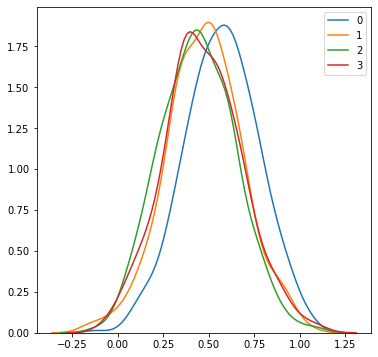

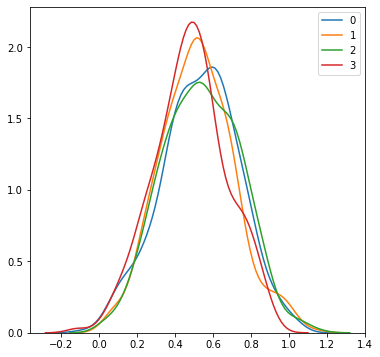

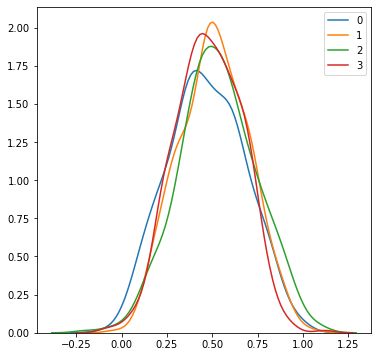

In [56]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(6,6))
p1=sns.kdeplot(df[0], shade=False)
p1=sns.kdeplot(df[1], shade=False)
p1=sns.kdeplot(df[2], shade=False)
p1=sns.kdeplot(df[3], shade=False)

fig, ax = plt.subplots(figsize=(6,6))
p2=sns.kdeplot(df1[0], shade=False)
p2=sns.kdeplot(df1[1], shade=False)
p2=sns.kdeplot(df1[2], shade=False)
p2=sns.kdeplot(df1[3], shade=False)

fig, ax = plt.subplots(figsize=(6,6))
p3=sns.kdeplot(df2[0], shade=False)
p3=sns.kdeplot(df2[1], shade=False)
p3=sns.kdeplot(df2[2], shade=False)
p3=sns.kdeplot(df2[3], shade=False)

In [20]:
from scipy.interpolate     import UnivariateSpline as sp
from sklearn.mixture import GaussianMixture
import numpy as np
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt


def cause(n,k,p1,p2):
  g = GaussianMixture(k, covariance_type = 'diag')
  g.means_   = p1*np.random.randn(k,1)
  g.covariances_  = np.power(abs(p2*np.random.randn(k,1)+1),2)
  g.weights_ = abs(np.random.rand(k))
  g.weights_ = g.weights_/sum(g.weights_)
  return scale(g.sample(n)[0])

In [23]:
x = cause(1000,3,2,2)
d = 2
g = np.linspace(min(x)-np.std(x),max(x)+np.std(x),d)
sp(g, np.random.randn(d), k=(1))(x.flatten())[:,np.newaxis]


array([-0.53768611, -0.55924311, -0.54031065, -0.60467079, -0.54984394,
       -0.55907782, -0.49585777, -0.52832575, -0.53235536, -0.53814322,
       -0.55798805, -0.57572241, -0.54077924, -0.55236551, -0.51639397,
       -0.52873923, -0.52508286, -0.56672805, -0.56397379, -0.5070798 ,
       -0.57705603, -0.53468695, -0.54791201, -0.51296586, -0.52373951,
       -0.53027239, -0.58386224, -0.49814329, -0.58888397, -0.48815315,
       -0.5678085 , -0.50645237, -0.55752404, -0.49883074, -0.49235673,
       -0.51506064, -0.53725932, -0.57432974, -0.5581908 , -0.48563631,
       -0.55698627, -0.55246076, -0.52763275, -0.50409264, -0.53957834,
       -0.54256156, -0.56767407, -0.51693621, -0.5667773 , -0.5183704 ,
       -0.56107257, -0.59472286, -0.56262231, -0.54436823, -0.56052326,
       -0.53274897, -0.57733481, -0.56271847, -0.599647  , -0.54268541,
       -0.59587934, -0.54813888, -0.54950502, -0.54319504, -0.55639073,
       -0.56144821, -0.5229645 , -0.55270037, -0.52939279, -0.55